# Define functions for import FASTA and FASTQ files
Define functions to import the FASTA file of template barcodes and FASTQ sequencing reads

In [18]:
import gzip
import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt

def import_fasta(path, pbar = None, sample_id = None):
  file = open(path)

  sequences = []

  pbar_desc = 'Loading FASTA: {}'.format(path)

  if sample_id is not None:
    pbar_desc = 'SAMPLE {}: '.format(sample_id) + pbar_desc
  if pbar is None:
    pass
  else:
    pbar.set_description(pbar_desc)
    pbar.unit = ' seqs'
    pbar.dynamic_ncols=True
    pbar.reset()
    close_pbar = False

  cur_name, cur_sequence = '',''
  for line in file:
    if line[0]=='>':
      if cur_sequence != '':
        sequences.append((cur_name, cur_sequence))
        if pbar is not None:
          pbar.update(1)
      cur_name = line[1:].strip()
      cur_sequence = ''
    else:
      cur_sequence += line.strip()
  sequences.append((cur_name, cur_sequence))

  if pbar is not None and close_pbar:
        pbar.close()

  return sequences


def import_fastq(path, max_reads = None, 
                 pbar = None, sample_id = None, 
                 max_sequence_length = 150, 
                 sequence_pretruncate = 0):
  if max_reads is None:  max_reads = float('inf')

  file = gzip.open(path, 'rt')
  
  sequences = []

  pbar_desc = 'Loading FASTQ: {}'.format(path)
  if sample_id is not None:
    pbar_desc = 'SAMPLE {}: '.format(sample_id) + pbar_desc
  if pbar is None:
    pbar = tqdm.tqdm(desc=pbar_desc, unit=' reads', dynamic_ncols = True)
    close_pbar = True
    pass
  else:
    pbar.set_description(pbar_desc)
    pbar.unit = ' reads'
    pbar.dynamic_ncols = True
    pbar.reset()
    close_pbar = False

  lines = [file.readline() for _ in range(4)]
  while lines[-1] != '' and len(sequences) < max_reads:
    cur_name = lines[0].split(" ")[0]
    cur_sequence = lines[1].strip()
    cur_sequence = cur_sequence[sequence_pretruncate:]
    if max_sequence_length is not None:
      cur_sequence = cur_sequence[:max_sequence_length]

    sequences.append((cur_name, cur_sequence))
    if pbar is not None:
      pbar.update(1)

    lines = [file.readline() for _ in range(4)]

  print("Loading sequences from {} ({})... Done!".format(path, len(sequences)))
  if pbar is not None and close_pbar:
    pbar.close()
  return sequences

def sequence_complement(seq, memo = {}):
  complements = {'A':'T', 'T':'A', 'G':'C', 'C':'G', '*':'*', 'N':'N'}
  if seq not in memo:
    memo[seq] = ''.join([complements[nt] for nt in reversed(seq)])
    
  return memo[seq]

def import_fastq_2way(path_f, path_r, max_reads = None, pbar = None, sample_id = None, max_sequence_length = None, sequence_pretruncate = 0):
  reads_forward = import_fastq(path_f, max_reads = max_reads, pbar = pbar, sample_id = sample_id, max_sequence_length = max_sequence_length, sequence_pretruncate = sequence_pretruncate)
  reads_reverse = import_fastq(path_r, max_reads = max_reads, pbar = pbar, sample_id = sample_id, max_sequence_length = max_sequence_length, sequence_pretruncate = sequence_pretruncate)
  
  # Combine forward and reverse reads into the same list
  reads_all = []
  
  for i, ((n1, s1), (n2, s2)) in enumerate(zip(reads_forward, reads_reverse)):
    if n1 == n2:
      s2 = sequence_complement(s2)
      reads_all.append((n1, (s1, s2)))
    else:
      print("\nWarning: Inconsistent forward/reverse read {} in {} and {}".format(i, path_f, path_r))

  return reads_all

def plot_counts_bar(templates, counts, output_prefix, title = None):
  bar_x = np.arange(len(templates))
  bar_heights = counts
  bar_width = 0.9
  bar_tick_labels = [name for name in templates]
  ylims = (0, max(counts)*1.02+.01)

  plt.figure(figsize=((len(templates)/2.5),6))
  plt.bar(x = bar_x, height = bar_heights, width = bar_width, data = counts)
  plt.ylabel('Counts')
  plt.xticks(bar_x, bar_tick_labels, rotation='vertical')

  for x, c in zip(bar_x, counts):
    plt.text(x, ylims[1]/50., str(c), horizontalalignment = 'center', verticalalignment = 'bottom', rotation='vertical')

  plt.ylim(ylims)

  if title is not None:
    plt.title(title)

  plt.savefig('{}_counts_bar.pdf'.format(output_prefix), bbox_inches='tight')

def fastq_analysis(path_f, path_r, template, max_reads, output_prefix):

    master_for = 'GGCTATGAGACTGTTCGCTAATCAC'
    master_rev = 'CCCTTTGTGGGCACAGTTTAGTCTC'
    
    template_list = import_fasta(template)
    reads_all = import_fastq_2way(path_f, path_r, max_reads = max_reads)

    # Flatten reads_all
    seq_all = [sublist[1] for sublist in reads_all]
    seq_flat = [item for sublist in seq_all for item in sublist]

    # Plot read length histogram
    read_lengths = []
    [read_lengths.append(len(reads)) for reads in seq_flat]

    plt.hist(read_lengths)
    plt.savefig('reads_hist.pdf', bbox_inches = 'tight')

    # String matching 
    counts = []
    person = []

    for template in template_list:
        person.append(template[0])
        barcode = template[1]
        query_pattern = str(master_for + '.....' + barcode + '.....' + master_rev)
        rex = re.compile(query_pattern)
        counts.append(len(rex.findall(','.join(seq_flat))))
    
    print(sum(counts)/len(seq_flat))
        
    plot_counts_bar(person, counts, output_prefix)

# Define inputs and outputs
Define path for forward and reverse reads and provide a unique file ID for the outputs

Loading FASTQ: Mollibrary-v2_S6_L001_R1_001.fastq.gz: 3600980 reads [01:02, 57791.56 reads/s]


Loading sequences from Mollibrary-v2_S6_L001_R1_001.fastq.gz (3600980)... Done!


Loading FASTQ: Mollibrary-v2_S6_L001_R2_001.fastq.gz: 3600980 reads [01:05, 55233.31 reads/s]


Loading sequences from Mollibrary-v2_S6_L001_R2_001.fastq.gz (3600980)... Done!
0.4132772189792779


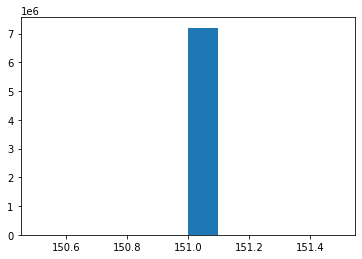

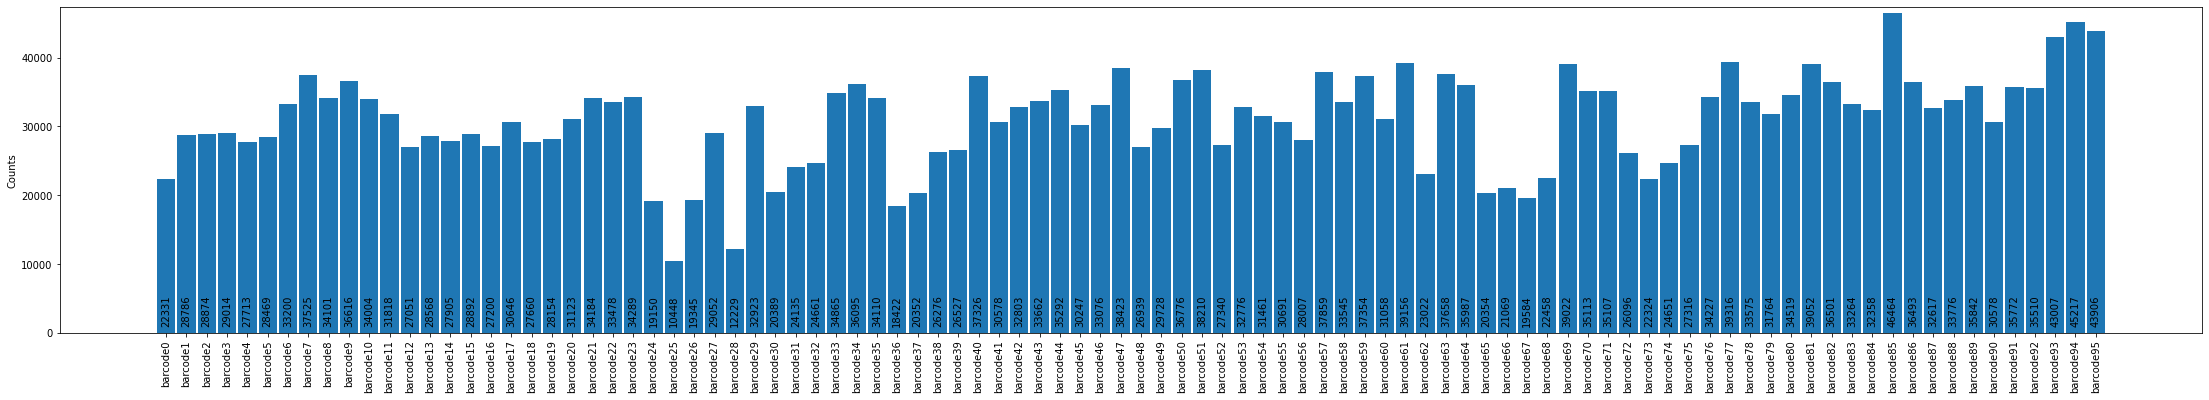

In [19]:
path_f = 'Mollibrary-v2_S6_L001_R1_001.fastq.gz'
path_r = 'Mollibrary-v2_S6_L001_R2_001.fastq.gz'
output_prefix = 'TRACER_v2_NEB_MiSeq'
template = 'templates.fasta'
max_reads = None

fastq_analysis(path_f, path_r, template, max_reads, output_prefix)